# Style Aligned Artwork Datasets (SALADs)
### Code to reproduce fruit-SALAD_10k

## 1. Find style reference images
This is a manual trial and error approach to find suitable text prompts and produce style reference images.

In [ ]:
from diffusers import DiffusionPipeline
import torch
import mediapy

deviceB = "cuda:1"
reference_pipeline = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
reference_pipeline.to(deviceB)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


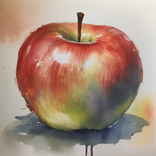
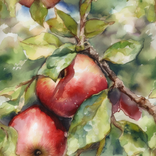
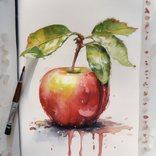
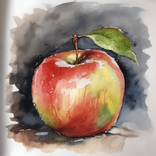
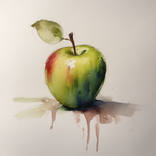
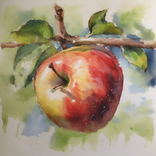

In [2]:
prompt = "watercolor sketch of an apple, aquarelle, wet paint"
images = []
for i in range(6):
    image = reference_pipeline(prompt=prompt, num_inference_steps=50, height=1024, width=1024).images[0]
    images.append(image)
mediapy.show_images(images, height=156)

#### cherry pick style reference image

In [3]:
images[0].save("references/1.png")

## 2. Test style aligned image generation
Using the style reference images and prepared text prompts to test the style on all fruit categories.

In [ ]:
from diffusers import StableDiffusionXLPipeline, DDIMScheduler
import torch
import sa_handler
from diffusers.utils import load_image
import inversion
import numpy as np

deviceA = "cuda:0"
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
    clip_sample=False, set_alpha_to_one=False)

style_aligned_pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True,
    scheduler=scheduler
).to(deviceA)

#### make inversion reference

In [5]:
source_prompt = "watercolor sketch of an apple, aquarelle, wet paint"
image_path = "references/1.png"

num_inference_steps = 50
x0 = np.array(load_image(image_path).resize((1024, 1024)))
zts = inversion.ddim_inversion(style_aligned_pipeline, x0, source_prompt, num_inference_steps, 2)

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.81it/s]


#### generate style aligned images

  0%|          | 0/50 [00:00<?, ?it/s]


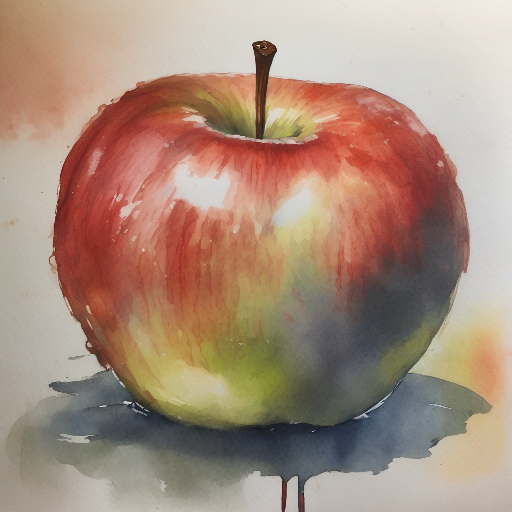
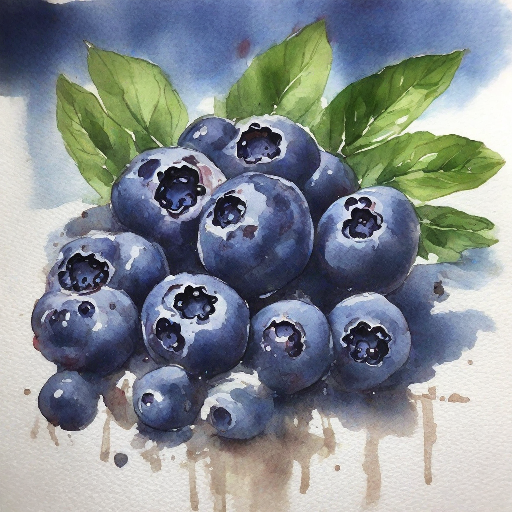
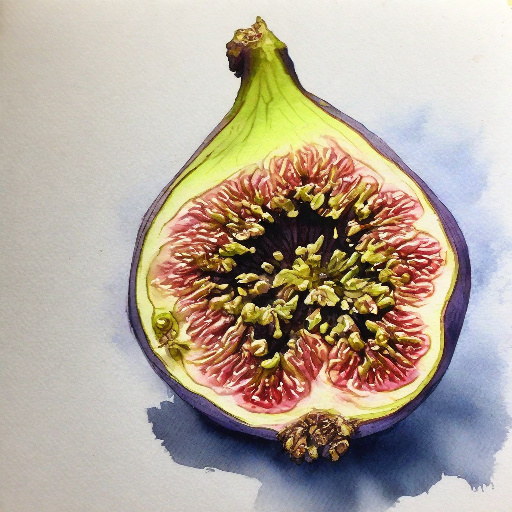
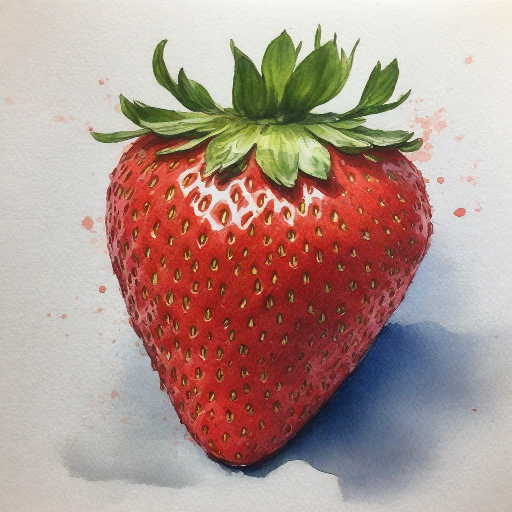
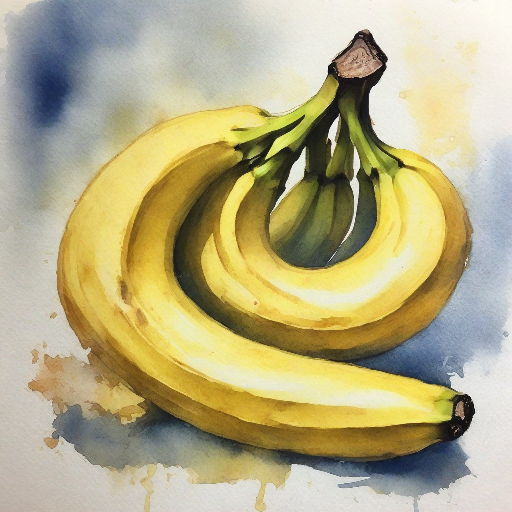

In [11]:
test_fruits = ['blueberries', 'a fig', 'a strawberry', 'bananas']
fruit_prompts = [f"watercolor sketch of {fruit}, aquarelle, wet paint" for fruit in test_fruits]
fruit_prompts.insert(0, source_prompt) # first needs to be the style reference prompt

shared_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
shared_score_scale = 0.8
num_inference_steps = 50

handler = sa_handler.Handler(style_aligned_pipeline)
sa_args = sa_handler.StyleAlignedArgs(
    share_group_norm=True, share_layer_norm=True, share_attention=True,
    adain_queries=True, adain_keys=True, adain_values=False,
    shared_score_shift=shared_score_shift, shared_score_scale=shared_score_scale,)
handler.register(sa_args)

zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(123)
latents = torch.randn(len(fruit_prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                      dtype=style_aligned_pipeline.unet.dtype,).to(deviceA)
latents[0] = zT

test_images = style_aligned_pipeline(fruit_prompts, 
                    latents=latents,
                    callback_on_step_end=inversion_callback,
                    num_inference_steps=num_inference_steps, guidance_scale=10.0).images

handler.remove()

mediapy.show_images(test_images)

# 3. Generate fruit-SALAD_100
Produces 10 fruit categories in 10 styles. This is without variations. 

In [ ]:
def make_reference(image_path, prompt):
    img = load_image(image_path)
    x0 = np.array(img.resize((1024, 1024)))
    zts = inversion.ddim_inversion(style_aligned_pipeline, x0, prompt, num_inference_steps, 2)
    return zts

def hundred_generation(prompts, style_idx, zts):
    handler = sa_handler.Handler(style_aligned_pipeline)
    sa_args = sa_handler.StyleAlignedArgs(
        share_group_norm=True, share_layer_norm=True, share_attention=True,
        adain_queries=True, adain_keys=True, adain_values=False,
        shared_score_shift=shared_score_shift, shared_score_scale=shared_score_scale,)
    handler.register(sa_args)

    zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

    g_cpu = torch.Generator(device='cpu')
    g_cpu.manual_seed(123)

    k = 0
    for object_prompts in prompts:
        latents = torch.randn(len(object_prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                              dtype=style_aligned_pipeline.unet.dtype,).to(deviceA)
        latents[0] = zT

        images_batch = style_aligned_pipeline(object_prompts, latents=latents,
                            callback_on_step_end=inversion_callback,
                            num_inference_steps=num_inference_steps, guidance_scale=10.0).images
        for i, img in enumerate(images_batch):
            if i != 0:
                img.save(f"fruit-SALAD_100/{k}_{style_idx}.png")
                k += 1
    handler.remove()

In [ ]:
import csv
shared_score_shift = np.log(2)
shared_score_scale = 0.8
num_inference_steps = 50
all_prompts = [row[0] for row in csv.reader(open('prompts.csv', newline=''))]
all_prompts = [all_prompts[i:i+10] for i in range(0, len(all_prompts), 10)]

for style_idx, prompts in enumerate(all_prompts):
    src_style = prompts[3] # assuming style reference fruits are apples
    zts = make_reference(image_path=f"style_references/{style_idx}.png", prompt=src_style)
    
    object_promptsA = [src_style] + prompts[:5] # process in batches due to memory constraints 
    object_promptsB = [src_style] + prompts[5:10]

    hundred_generation(prompts=[object_promptsA]+[object_promptsB], style_idx=style_idx, zts=zts)                   

#### make 10x10 overview plot

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

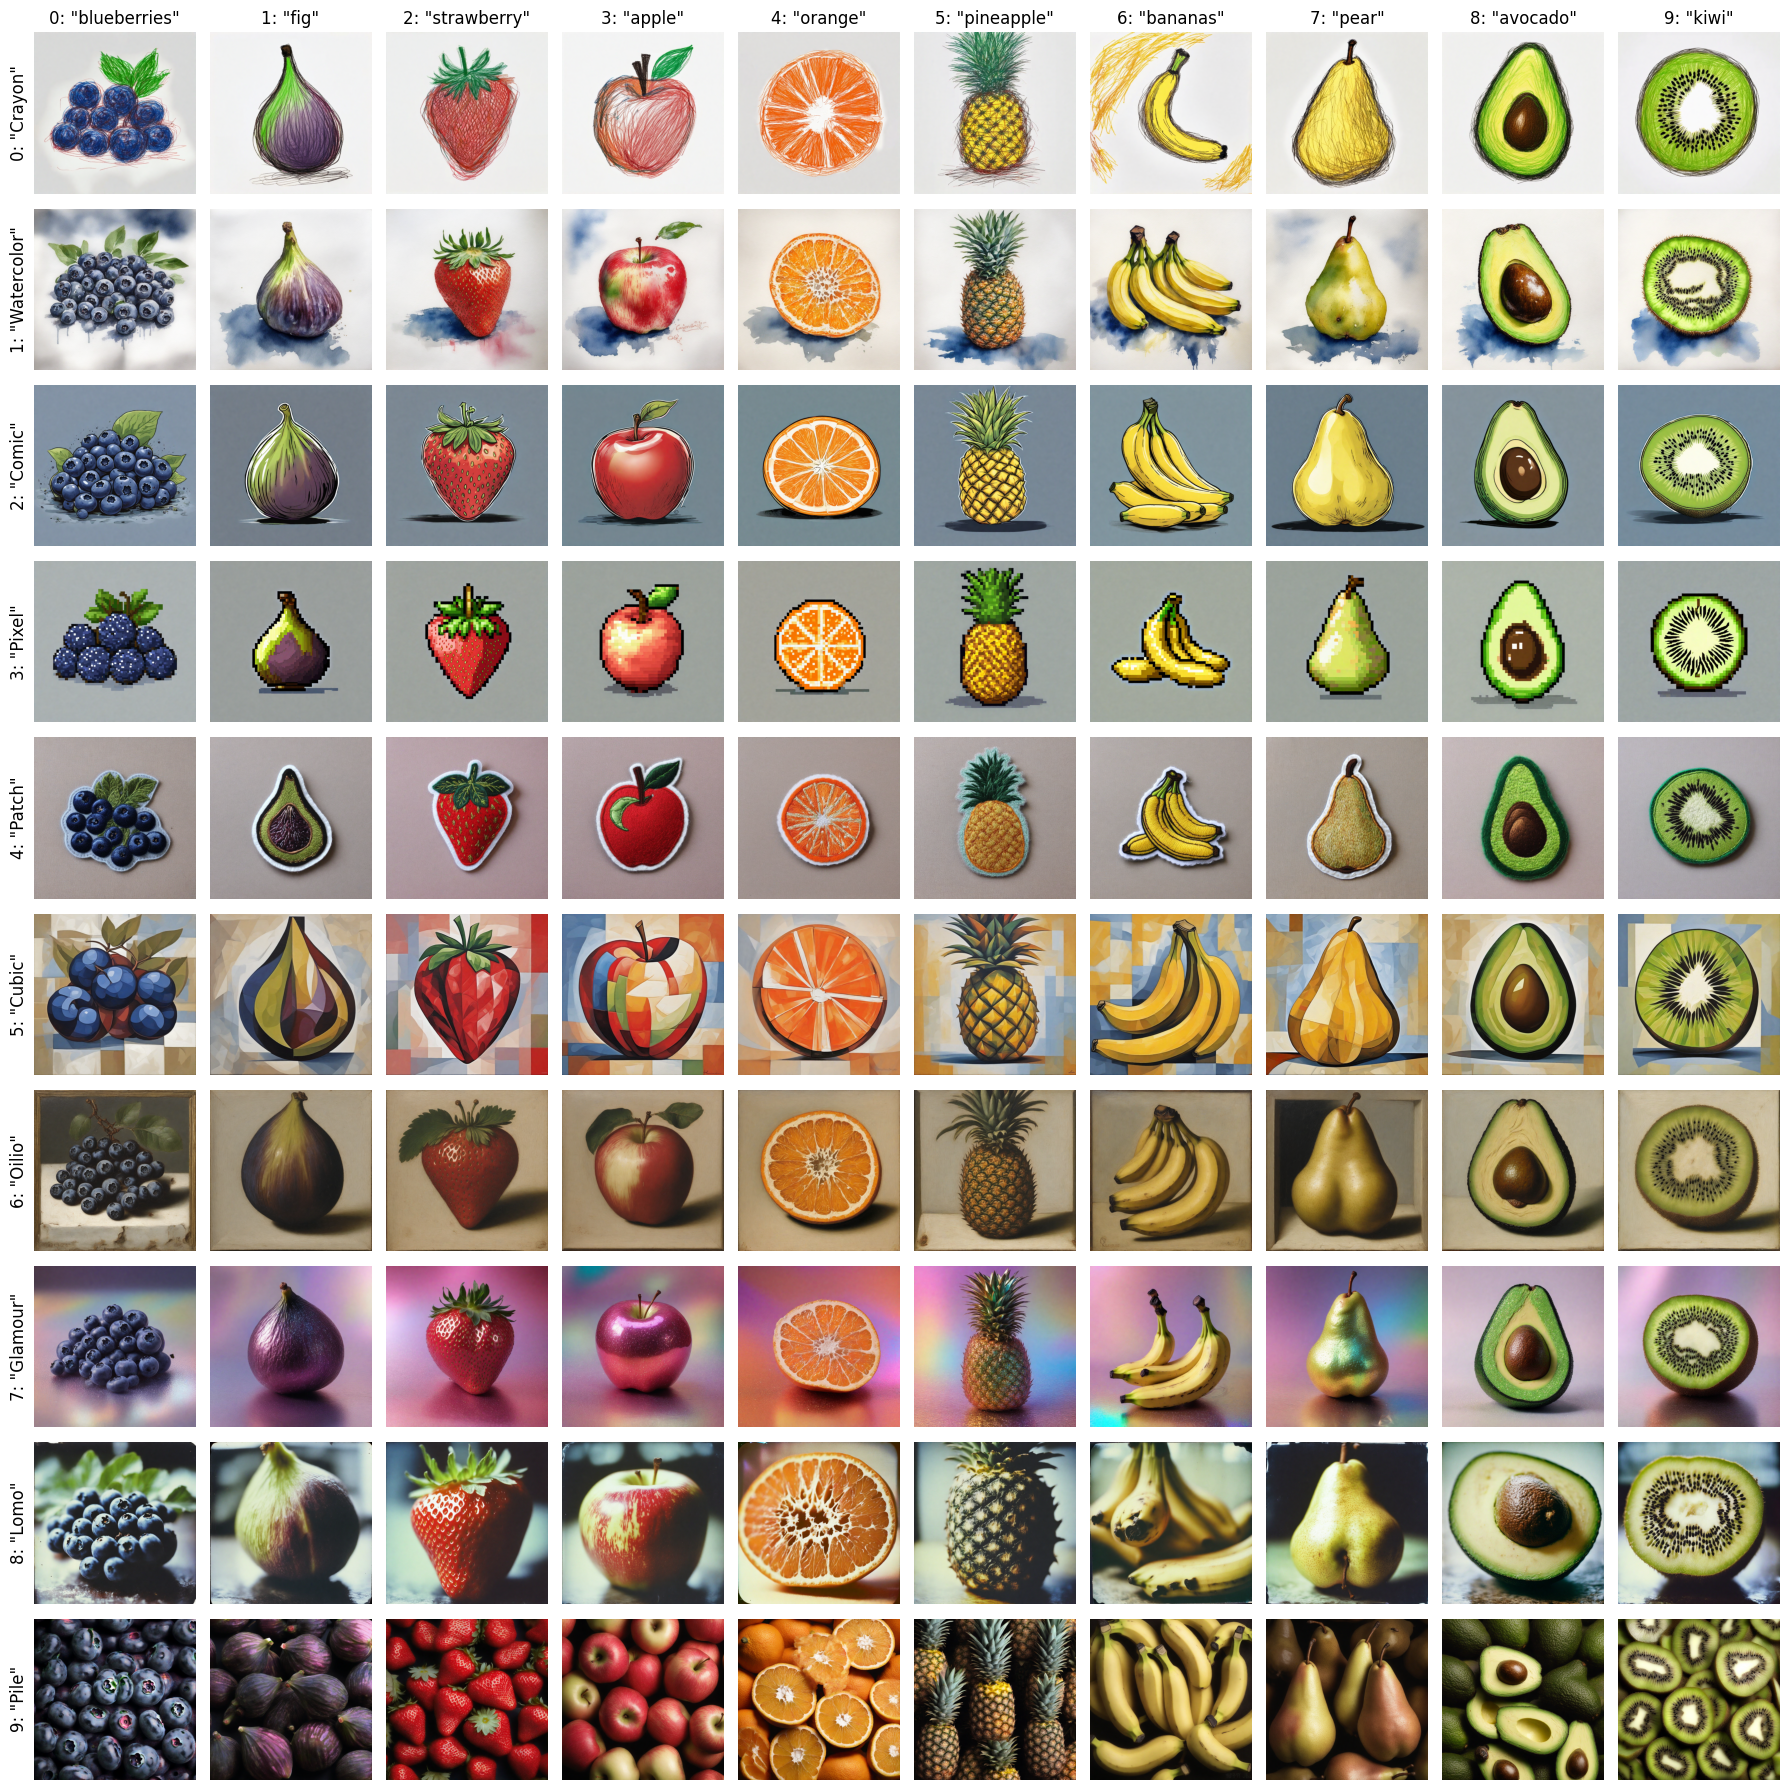

In [9]:
base_directory = "fruit-SALAD_100/"
object_prompts = [
    'blueberries', 
    'fig', 
    'strawberry', 
    'apple', 
    'orange', 
    'pineapple', 
    'bananas', 
    'pear', 
    'avocado', 
    'kiwi'
    ]

style_prompts = [
    'Crayon',
    'Watercolor',
    'Comic',
    'Pixel',
    'Patch',
    'Cubic',
    'Oilio',
    'Glamour',
    'Lomo',
    'Pile'
    ]

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(18, 18))
axes = axes.flatten()

for i in range(10):
    for j in range(10):
        img = Image.open(base_directory + f"{j}_{i}.png")
        axes[i*10+j].imshow(img)
for i, col in enumerate(object_prompts):
    axes[i].set_title(f'{i}: "{col}"', fontsize='large')
for i, row in enumerate(style_prompts):
    axes[i*10].set_ylabel(f'{i}: "{row}"', rotation=90, size='large')
# hide axis but keep labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.savefig('overview.png')
plt.show()
plt.close(fig)

## 4. Generate fruit-SALAD_10k
Produces 10 fruit categories in 10 styles in 100 variations. 

In [ ]:
def full_generation(prompts, style_idx, zts, src_prompt):
    handler = sa_handler.Handler(style_aligned_pipeline)
    sa_args = sa_handler.StyleAlignedArgs(
        share_group_norm=True, share_layer_norm=True, share_attention=True,
        adain_queries=True, adain_keys=True, adain_values=False,
        shared_score_shift=shared_score_shift, shared_score_scale=shared_score_scale,)
    handler.register(sa_args)

    zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

    g_cpu = torch.Generator(device='cpu')
    g_cpu.manual_seed(123)

    for k, p in enumerate(prompts):
        for iterate in range(20): # 100 variations (20x5 batches)
            object_prompts = [src_prompt] + [p for n in range(5)]   

            latents = torch.randn(len(object_prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                                  dtype=style_aligned_pipeline.unet.dtype,).to(device)
            latents[0] = zT

            images_batch = style_aligned_pipeline(object_prompts, latents=latents,
                                callback_on_step_end=inversion_callback,
                                num_inference_steps=num_inference_steps, guidance_scale=10.0).images

            for i, img in enumerate(images_batch):
                if i != 0:
                    img.save(f"fruit-SALAD_10k/{k}_{style_idx}_{(i-1)+(5*iterate)}.png")
         
    handler.remove()

In [ ]:
import csv
shared_score_shift = np.log(2)
num_inference_steps = 50
sss_list = [0.8,0.8,0.8,0.8,0.8,0.8,0.85,0.8,0.8,0.8]
num_inference_steps = 50
all_prompts = [row[0] for row in csv.reader(open('prompts.csv', newline=''))]
all_prompts = [all_prompts[i:i+10] for i in range(0, len(all_prompts), 10)]

for style_idx, prompts in enumerate(all_prompts):
    src_style = prompts[3] # assuming style reference fruits are apples
    zts = make_reference(image_path=f"style_references/{style_idx}.png", prompt=src_style)
    full_generation(prompts=prompts, style_idx=style_idx, zts=zts, src_prompt=src_style)                   

## 5. Manually replace instances
Re-generates specific instances of category-style combination.

In [ ]:
def generation_specific(object_prompts, style_idx, object_idx, zts, instance, seed):
    handler = sa_handler.Handler(style_aligned_pipeline)
    sa_args = sa_handler.StyleAlignedArgs(
        share_group_norm=True, share_layer_norm=True, share_attention=True,
        adain_queries=True, adain_keys=True, adain_values=False,
        shared_score_shift=shared_score_shift, shared_score_scale=shared_score_scale,)
    handler.register(sa_args)

    zT, inversion_callback = inversion.make_inversion_callback(zts, offset=5)

    g_cpu = torch.Generator(device='cpu')
    g_cpu.manual_seed(seed)
    
    print(object_prompts)
    latents = torch.randn(len(object_prompts), 4, 128, 128, device='cpu', generator=g_cpu,
                          dtype=style_aligned_pipeline.unet.dtype,).to(device)
    latents[0] = zT

    images_a = style_aligned_pipeline(object_prompts, latents=latents,
                        callback_on_step_end=inversion_callback,
                        num_inference_steps=num_inference_steps, guidance_scale=10.0).images
    images_a[1].save(f"replace/{object_idx}_{style_idx}_{instance}.png")
    handler.remove()

In [ ]:
import csv, re
num_inference_steps = 50
shared_score_shift = np.log(2)
shared_score_scale = 0.8
seed = 456 # try different seeds for different results
all_prompts = [row[0] for row in csv.reader(open('prompts.csv', newline=''))]
all_prompts = [all_prompts[i:i+10] for i in range(0, len(all_prompts), 10)]

# all_instances = ['4_7_2.png', '6_8_4.png', '4_5_5.png', '0_5_9.png', '0_5_4.png', '8_7_0.png', '0_5_6.png', '1_8_5.png', '0_8_9.png', '0_5_1.png']
all_instances = ['4_7_6.png']
  
for a in all_instances:
    fruit_idx, style_idx, instance = map(int, re.match(r"(\d+)_(\d+)_(\d+).png", a).groups())
    print(a, fruit_idx, style_idx, instance)
    prompts = all_prompts[style_idx]
    src_style = prompts[3]
    zts = make_reference(image_path=f"style_references/{style_idx}.png", prompt=src_style)

    object_prompts = [src_style] + [prompts[fruit_idx]]

    generation_specific(object_prompts=object_prompts, style_idx=style_idx, object_idx=fruit_idx, zts=zts, instance=instance, seed=seed)                 
